In [ ]:


from itertools import product
from datasets import load_dataset,load_from_disk
import config
import os
import pandas as pd
import util
import torch
import plotting
from scipy.stats import power_divergence

import config
from itertools import product



In [ ]:
import os
import pandas as pd
import torch
from itertools import product
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import threading
from multiprocessing import Manager

from scipy.stats import entropy
stats_lock = threading.Lock()


manager = Manager()
dataset_cache = manager.dict()
df_cache = manager.dict()
stats = manager.list()  

def get_cached_dataset(dataset_name):
    if dataset_name not in dataset_cache:
        dataset_cache[dataset_name] = load_dataset(dataset_name)["train"].select_columns("stage")
    return dataset_cache[dataset_name]

def get_prepared_df(dataset_name, model_type):
    cache_key = (dataset_name, model_type)

    if cache_key not in df_cache:        
        dataset = get_cached_dataset(dataset_name)
        model_name = dataset_name + "_" + model_type + "_random"
        
        influence_output_dir = os.path.join(
            "./influence_mean_normalized",
            os.path.basename(model_name),
            "_".join([(os.path.basename(dataset_name) + "_" + "train[0%:100%]")] * 2),
        )
        
        df = pd.DataFrame({
            int(result_checkpoint.replace("checkpoint-", "")): torch.load(
                os.path.join(influence_output_dir, result_checkpoint),
                weights_only=True,
                map_location="cpu"
            ).numpy().flatten()
            for result_checkpoint in os.listdir(influence_output_dir)
        })

        df = df.reindex(sorted(df.columns), axis=1)
        df["stage"] = dataset.to_pandas()

        df_cache[cache_key] = df

    return df_cache[cache_key]


all_combinations = []

for model_type in config.model_types: 
    curricula = [model_type + c for c in config.influence_curricula] + config.baseline_curricula
    for curriculum in curricula:
        for dataset in config.datasets:
            all_combinations.append((dataset, model_type, curriculum))


def process_combination(combination):

    dataset_name, model_type, curriculum_a_name = combination
    local_stats = []
    
    # try:
    df = get_prepared_df(dataset_name, model_type)

    epsilon = 1e-100
    bins = 100

    curriculum_a = util.get_curriculum(dataset_name, curriculum_a_name)

    examples_a = df.iloc[torch.cat(curriculum_a).flatten()]
    
    all_stages = examples_a["stage"].unique()
    
    
    bin_size = len(examples_a) // bins

    chunks = [
        examples_a["stage"][i:i+bin_size]
        for i in range(0, len(examples_a), bin_size) if i + bin_size < len(examples_a)
    ]

    for idx, a in enumerate(chunks):
        d = a.value_counts().reindex(all_stages, fill_value=epsilon)
        d["chunk"] = idx
        d["curriculum"] = curriculum_a_name
        d["dataset"] = dataset_name
        d["model_type"] = model_type
        local_stats.append(d)

    # except Exception as e:
    #     print(f"[Error] Skipping: {dataset_name}, {model_type}, {curriculum_a_name}, {curriculum_b_name}")
    #     print("Reason:", str(e))

    with stats_lock:
        stats.extend(local_stats)


import random
from itertools import chain, zip_longest
from collections import defaultdict


cache_path = (os.path.join("./plotting_notebooks/cache/","source_counts.csv"))

if True or not os.path.exists(cache_path):

    first_batch = all_combinations[:3]
    remaining_batch = all_combinations[3:]



    with ThreadPoolExecutor(max_workers=3) as executor:
        futures = [executor.submit(process_combination, c) for c in first_batch]
        for _ in tqdm(as_completed(futures), total=len(futures), desc="Processing (3 workers)") :
            pass


    with ProcessPoolExecutor(max_workers=32) as executor:
        futures = [executor.submit(process_combination, c) for c in remaining_batch]
        for _ in tqdm(as_completed(futures), total=len(futures), desc="Processing (64 workers)") :
            pass


    stats_df = pd.concat([pd.DataFrame(s).T for s in stats], axis=0)
    stats_df.to_pickle(cache_path)


stats_df = pd.read_pickle(cache_path)

Processing (64 workers): 100%|██████████| 81/81 [00:13<00:00,  6.02it/s]


In [ ]:
list(stats)

[stage
 C1: Child Directed Speech                                          6362
 C4: Educational                                                    2061
 C2: Children's Books                                                808
 C5: Written English                                                 496
 C3: Dialogue                                                        273
 chunk                                                                 0
 curriculum                     llama_incr_influence_epoch_repetition.pt
 dataset                      loris3/stratified_equitoken_10m_curriculum
 model_type                                                        llama
 Name: count, dtype: object,
 stage
 C1: Child Directed Speech                                          6362
 C4: Educational                                                    2061
 C2: Children's Books                                                808
 C5: Written English                                                 496
 C3: Dia

In [ ]:
import seaborn as sns

/tmp/ipykernel_555960/2001975458.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_df = data[stages + ["curriculum", "chunk"]].fillna(0)
/tmp/ipykernel_555960/2001975458.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_positions.extend(range(x, x + s[i]))
/tmp/ipykernel_555960/2001975458.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = x + s[i] + padding
/tmp/ipykernel_555960/20

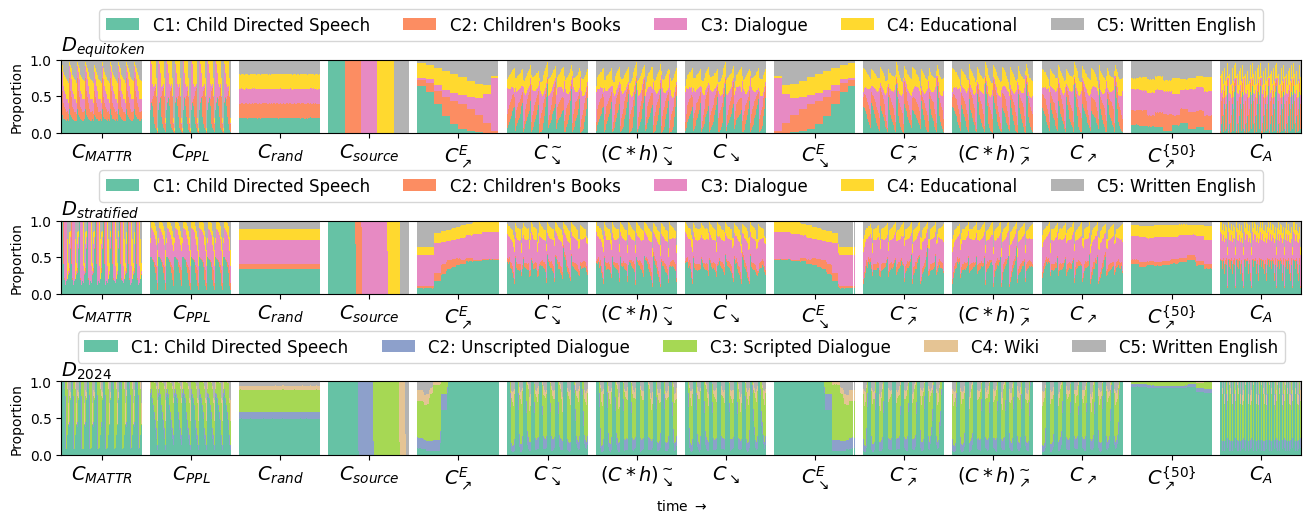

/tmp/ipykernel_555960/2001975458.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_df = data[stages + ["curriculum", "chunk"]].fillna(0)
/tmp/ipykernel_555960/2001975458.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_positions.extend(range(x, x + s[i]))
/tmp/ipykernel_555960/2001975458.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = x + s[i] + padding
/tmp/ipykernel_555960/20

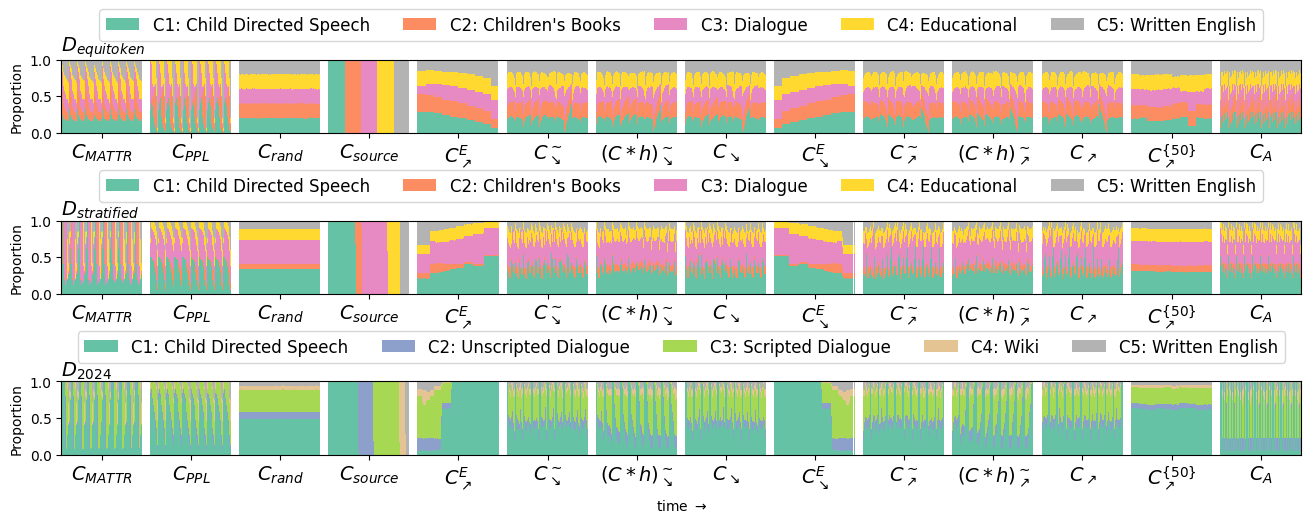

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import util
from sklearn.metrics.pairwise import cosine_similarity

def plot_proportions(model_type, skip_redundant=True):
    save_path = os.path.join("./autogenerated_figures", "source_distribution_over_time", f"{model_type}.png")

    norm_df = stats_df[stats_df["model_type"] == model_type].copy()

    datasets = norm_df['dataset'].unique()
    stages = sorted([c for c in norm_df.columns if "C" in c])
    left_group = ['random.pt']

    fig, axes = plt.subplots(
        len(datasets), 1,
        figsize=(16, 5),
        sharey=True,
    )

    palette = sns.color_palette("Set2")

    if len(datasets) == 1:
        axes = [axes]

    for row_idx, dataset in enumerate(datasets):
        axes[row_idx].set_title(util.rename_dataset(dataset), loc='left', fontsize=14, pad=2, fontweight='bold')

        random_df = None
        data = norm_df[norm_df['dataset'] == dataset]

        ax = axes[row_idx]

        pivot_df = data[stages + ["curriculum", "chunk"]].fillna(0)
        pivot_df = pivot_df.groupby(["curriculum", "chunk"]).mean()

        pivot_df = pivot_df.apply(lambda row: row / row.sum(), axis=1)

        pivot_df = pivot_df.loc[
                sorted(
                        pivot_df.index,
                        key=lambda idx: (
                            idx[0] not in config.baseline_curricula,  # baseline first (False < True)
                            idx[0],  # sort alphabetically by curriculum
                            idx[1]   # then by chunk
                        )
                    )
                ]


        
        s = pivot_df.groupby("curriculum").size()

        padding = 10
        bottom = pd.Series([0] * len(pivot_df), index=pivot_df.index)
        for ii, stage in enumerate(stages):
            if stage in pivot_df.columns:
                vals = pivot_df[stage]
                x_positions = []

                x = -0
                for i in range(len(s)):
                    x_positions.extend(range(x, x + s[i]))
                    x = x + s[i] + padding

                ax.bar(x_positions, vals, bottom=bottom, label=stage, width=1.0, color=palette[ii])
                bottom += vals

        ax.set_ylabel("Proportion")
        ax.set_ylim(0, 1)

        n_curricula = len(pivot_df.index.get_level_values(0).unique())
        cumulative_sum = np.cumsum(s)

        x_positions = cumulative_sum + np.arange(len(s)) * padding


        midpoints = x_positions - s / 2
        ax.set_xlim(0, x_positions[-1])
        ax.set_xticks(midpoints)
     
        ax.set_xticklabels([util.rename(i) for i in pivot_df.index.get_level_values(0).unique()], rotation=0,fontsize=14)

        a = axes[row_idx]
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = []
        unique_handles = []
        for handle, label in zip(handles, labels):
            if label not in unique_labels:
                if data[label].sum() > 0:
                    unique_labels.append(label)
                    unique_handles.append(handle)
        sorted_labels_handles = sorted(zip(unique_labels, unique_handles))
        sorted_labels, sorted_handles = zip(*sorted_labels_handles)

        a.legend(
            handles=sorted_handles,
            labels=sorted_labels,
            bbox_to_anchor=(0.5, 1.8),  
            loc='upper center',
            ncol=5,
            fontsize=12,
        )
        
    axes[-1].set_xlabel(f"time $\\rightarrow$")


    plt.subplots_adjust(hspace=1.2, top=0.9) 


    plt.rcParams.update({
        "text.usetex": False,
    })
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=1200, bbox_inches='tight', format="png")
    plt.show()

from itertools import product
import numpy as np
for model_type in config.model_types:
    plot_proportions(model_type, skip_redundant=True)
    
